In [ ]:
!pip3 install visdom

     |████████████████████████████████| 1.4MB 5.1MB/s 
     |████████████████████████████████| 204kB 34.1MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.8-cp36-none-any.whl size=1350602 sha256=ff7fe6676be95afb5e3a0215cd6246d88fcc6d44651091270119ca729d3d520e
  Stored in directory: /root/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Created wheel for torchfile: filename=torchfile-0.1.0-cp36-none-any.whl size=5713 sha256=f1bcb4e0059acec880e34f1f1d7d76f8b62c2393dc4cbce53564e1f6f7ebedab
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json
import visdom
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# from utils import to_var
# from data_utils import create_validation_data
# from vis_utils import imshow, plot_bbox, PlotLoss, ShowSample
from sklearn.model_selection import train_test_split
import cv2
np.set_printoptions(precision=2)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
root_path = '/content/gdrive/My Drive/data_sets/fish'
data_path = root_path + '/data'
annotation_path = root_path + '/annotations'

In [ ]:
#lets read annotations
def read_annotations(path):
    """ Read Bounding Boxes from a json file.
    """
    anno_classes = [f.split('_')[0] for f in os.listdir(path)]
    bb_json = {}
    
    for c in anno_classes:
        j = json.load(open(f'{path}/{c}_labels.json', 'r'))
        for l in j:
            if 'annotations' in l and len(l['annotations']) > 0:
                fname = l['filename'].split('/')[-1]
                bb_json[fname] = sorted(
                  l['annotations'], key=lambda x: x['height'] * x['width'])[-1]
    return bb_json

In [ ]:
bbs = read_annotations(annotation_path)
bbs.values()

dict_values([{'class': 'rect', 'height': 55.0, 'width': 91.0, 'x': 194.0, 'y': 131.0}, {'class': 'rect', 'height': 136.0, 'width': 156.0, 'x': 700.0, 'y': 61.0}, {'class': 'rect', 'height': 138.0, 'width': 134.0, 'x': 711.0, 'y': 101.0}, {'class': 'rect', 'height': 268.0, 'width': 80.0, 'x': 113.0, 'y': 235.0}, {'class': 'rect', 'height': 119.0, 'width': 196.0, 'x': 188.0, 'y': 61.0}, {'class': 'rect', 'height': 160.0, 'width': 116.0, 'x': 575.0, 'y': 177.0}, {'class': 'rect', 'height': 111.0, 'width': 182.0, 'x': 36.0, 'y': 214.0}, {'class': 'rect', 'height': 96.0, 'width': 157.0, 'x': 194.0, 'y': 88.0}, {'class': 'rect', 'height': 139.0, 'width': 108.0, 'x': 569.0, 'y': 59.0}, {'class': 'rect', 'height': 143.0, 'width': 113.0, 'x': 302.0, 'y': 112.0}, {'class': 'rect', 'height': 125.0, 'width': 245.0, 'x': 458.0, 'y': 126.0}, {'class': 'rect', 'height': 169.0, 'width': 88.0, 'x': 537.0, 'y': 535.0}, {'class': 'rect', 'height': 189.0, 'width': 85.0, 'x': 67.0, 'y': 117.0}, {'class': '

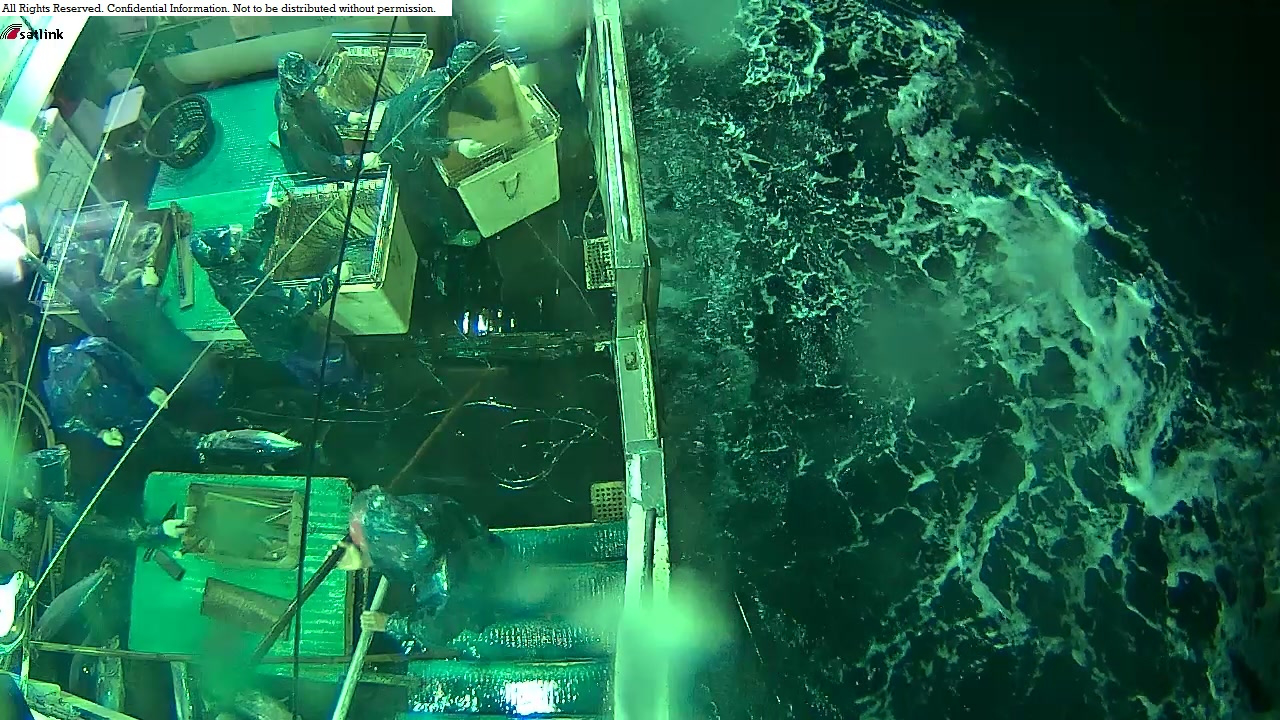

In [ ]:
#let's take a pick on data
files = glob(data_path+'/*/*.*')
Image.open(files[np.random.randint(0,len(files))])

In [ ]:
class myds(Dataset):
    '''
        ds : torchvision.datasets.ImageFolder
        spliter : a list containing valid indexes of ds
    '''
    def __init__(self,ds,spliter):
        super().__init__()
        self.ds = ds
        self.spliter = spliter
        self.dataset_size = len(self.spliter)
        self.classes = ds.classes
        self.imgs = [ds.imgs[i] for i in spliter]
        

    def __getitem__(self,index):
        return self.ds[self.x[index % self.dataset_size]]

    def __len__(self):
        return self.dataset_size
      
    def __classes__(self):
        return self.classes_
    
    def __imgs__(self):
        return self.imgs

class fish_ds(Dataset):
    '''
        ds : myds
        bboxes : boundry boxes of all files
        transform : torchvision.transform
    '''
    def __init__(self , ds , bboxes , transform = None , sz = 299):
        super().__init__()
        self.ds = ds
        self.bboxes = bboxes
        self.zero_box = {'class': 'rect', 'height': 0.0, 'width': 0.0, 'x': 0.0, 'y': 0.0}
        self.trfm = transform
        self.sz = sz
        
        if self.trfm is None :
            self.trfm = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.02),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self , index):
        img , label = self.ds.imgs[index]
        img_name = img.split('/')[-1]
        
        if img_name in self.bboxes.keys() :
            bb = self.bboxes[img_name]
        else :
            bb = self.zero_box
        
        image = Image.open(img).convert('RGB')
        image_w, image_h = image.size
        
        w_scale = self.sz / image_w
        h_scale = self.sz / image_h
        
        # transformations
        image_tensor = self.trfm(image)
        
        # normalize and scale bounding box
        bx, by, bw, bh = bb['x'], bb['y'], bb['width'], bb['height']
        bx, bw = (bx * w_scale) / self.sz, (bw * w_scale) / self.sz
        by, bh = (by * h_scale) / self.sz, (bh * h_scale) / self.sz
        
        # create target tensor (location and classification result)
        target_tensor = torch.zeros(4 + len(self.ds.classes))
        target_tensor[:4] = torch.FloatTensor([bx, by, bw, bh])
        target_tensor[4 + label] = 1
        
        # return image tensor, label tensor and bounding box tensor
        return image_tensor, target_tensor, (image_w, image_h)
    
    def __len__(self):
        return len(self.ds)

In [ ]:
data_ds = datasets.ImageFolder(data_path)
train_spliter , test_spliter = train_test_split( [i for i in range(len(data_ds))] ,test_size = 0.2 , random_state = 1234)

tra_ds = myds(data_ds , train_spliter)
tes_ds = myds(data_ds , test_spliter)

train_ds = fish_ds(tra_ds , bbs)
test_ds  = fish_ds(tes_ds , bbs)

train_dl = DataLoader(train_ds , batch_size = 32 , shuffle = True , num_workers=1)
test_dl  = DataLoader(test_ds  , batch_size = 32  , shuffle = True, num_workers=1)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

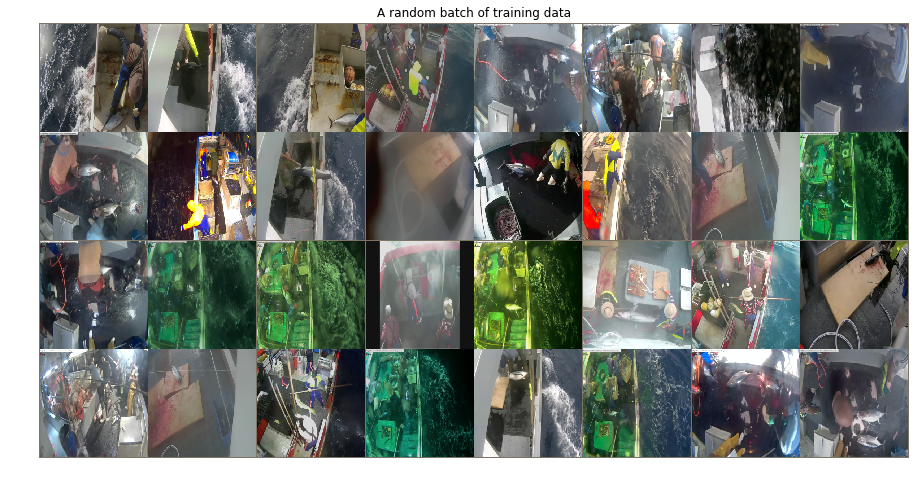

In [ ]:
#use data loader to figure some images
dataiter = iter(train_dl)
imgs, targets, sizes = next(dataiter)
img = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(16, 8))
imshow(img, title='A random batch of training data')

In [ ]:
def plot_bbox(img, bbox, w, h, color='red'):
    """ Plot bounding box on the image tensor. 
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)
    
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # bounding box
#     bb = np.array(bbox, dtype=np.float32)
    bx, by = bb[0] * w, bb[1] * h
    bw, bh = bb[2] * w, bb[3] * h
        
    # scale image
    img = cv2.resize(img, (w, h))
    
    # create BB rectangle
    rect = plt.Rectangle((bx, by), bw, bh, color=color, fill=False, lw=3)
    
    # plot
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect)
    plt.show()


torch.Size([3, 299, 299])
[0.55 0.28 0.32 0.18 0.   0.   0.   0.   0.   1.   0.   0.  ]
OTHER


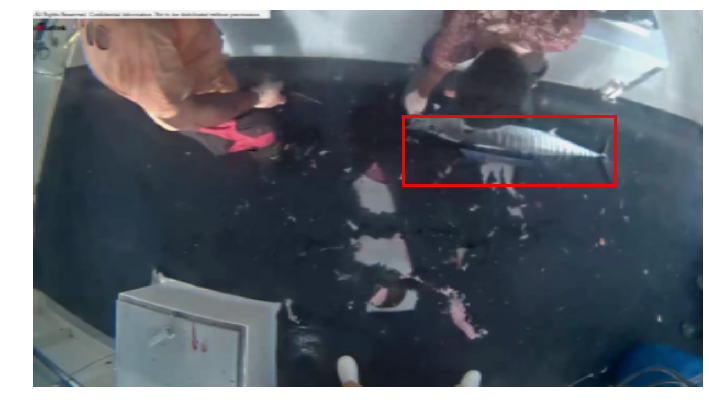

In [ ]:
# get one random data from training data
rnd_idx = np.random.choice(len(train_ds))
img_tensor, target_tensor, (img_w, img_h) = train_ds[rnd_idx]

# print size, label, and bounding box
print(img_tensor.size())
print(target_tensor.numpy())
bb = target_tensor[:4]
lbl = np.argmax(target_tensor) - 4
print(train_ds.ds.classes[lbl])

# plot image and bounding box
plot_bbox(img_tensor, bb, img_w, img_h)

In [ ]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)

In [ ]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_hidden=128, num_classes=8):
        super().__init__()
        self.num_classes = num_classes
        self.num_hidden = num_hidden
        
        # create cnn model
        cnn = get_model(model_name)

        # remove fc layers from cnn and add a new fc layer
        if hasattr(cnn, 'fc'):
            self.num_features = cnn.fc.in_features
        else:
            self.num_features = cnn.classifier.in_features
    
        fc = nn.Sequential(
            nn.Linear(self.num_features, self.num_hidden),
            nn.BatchNorm1d(self.num_hidden),
            nn.LeakyReLU(0.1, inplace=True)
        )
        
        if hasattr(cnn, 'fc'):
            cnn.fc = fc
        else:
            cnn.classifier = fc

        self.features = cnn
        
        # bounding box
        self.loc = nn.Linear(self.num_hidden, 4)
        # class = 8
        self.cls = nn.Linear(self.num_hidden, self.num_classes)
    
    def forward(self, x):
        x = self.features(x)      # extract features
        loc_out = self.loc(x)     # bbox location
        cls_out = self.cls(x)     # class scores
        
        return torch.sigmoid(loc_out), torch.sigmoid(cls_out)

In [ ]:
def l2_loss(output, target, mask=None):
    """ L2 loss function
    
    Inputs: 
        output: predicted outputs, bs * 8
        target: true outputs, bs * 8
    """
    dist = torch.pow(output - target, 2)
    flat = torch.sum(dist, 1).view(-1)
    return torch.mean(mask * flat) if mask is not None else torch.mean(flat)


def loss_func(output, target, alpha):
    output_loc, output_cls = output
    target_loc = target[:, :4]
    target_cls = target[:, 4:]

    mask = to_var((torch.max(output_cls.data, dim=1)[1] != 4).float())
    loc_loss = l2_loss(output_loc, target_loc, mask)
    cls_loss = l2_loss(output_cls, target_cls)
    
    total = loc_loss + (alpha * cls_loss)
    return total, loc_loss, cls_loss

In [ ]:
model_name = 'resnet34'
model = ClassifierLocalizer(model_name)
if torch.cuda.is_available(): model = model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)

In [ ]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [ ]:
def train_step(model, optimizer, train_dl, verbose=0, alpha=0.2):
    
    model.train()  # training phase
    
    epoch_loss = 0.0
    epoch_cls_loss = 0.0
    epoch_loc_loss = 0.0
    
    for data, target, _ in tqdm(train_dl):
        data, target = to_var(data), to_var(target)

        # forward
        output = model(data)
        
        # loss
        loss, loc_loss, cls_loss = loss_func(output, target, alpha)
        
        epoch_loss += loss.data.item() / len(train_dl)
        epoch_loc_loss += loc_loss.data.item() / len(train_dl)
        epoch_cls_loss += cls_loss.data.item() / len(train_dl)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if verbose > 0:
            print(f"loss:{loss.data.item()}")
            print(f"loc loss:{loc_loss.data.item()}")
            print(f"cls loss:{cls_loss.data.item()}")

    return epoch_loss, epoch_loc_loss, epoch_cls_loss


def evaluate_step(model, valid_dl, alpha=0.2):
    model.eval()  # testing phase

    epoch_loss = 0.0
    epoch_cls_loss = 0.0
    epoch_loc_loss = 0.0
    
    for data, target, _ in tqdm(valid_dl):
        data, target = to_var(data), to_var(target)
        
        # forward 
        output = model(data)
        
        # loss
        loss, loc_loss, cls_loss = loss_func(output, target, alpha)
        
        epoch_loss += loss.data.item() / len(valid_dl)
        epoch_loc_loss += loc_loss.data.item() / len(valid_dl)
        epoch_cls_loss += cls_loss.data.item() / len(valid_dl)
        
    return epoch_loss, epoch_loc_loss, epoch_cls_loss

In [ ]:
train_loss_hist = []
test_loss_hist = []
alpha = 0.9
best_loss = float('inf')
best_weights = None


In [ ]:
######################################TRAIN#######################################

num_epochs = 10



for epoch in range(num_epochs):
    
    # run one epoch of training and validate model on validation dataset
    trn_loss, trn_loc_loss, trn_cls_loss = train_step(model, optimizer, train_dl, alpha=alpha)
    val_loss, val_loc_loss, val_cls_loss = evaluate_step(model, test_dl, alpha=alpha)    
    
    
    ##########HISTORY#########
    train_loss_hist.append([trn_loss , trn_loc_loss , trn_cls_loss])
    test_loss_hist.append([val_loss , val_loc_loss , val_cls_loss])
    ##########################
#     # visualization using Visddom
#     ttl_loss.append([trn_loss, val_loss])
#     loc_loss.append([trn_loc_loss, val_loc_loss])
#     cls_loss.append([trn_cls_loss, val_cls_loss])

#     sample1.show()
#     sample2.show()
#     sample3.show()

    # save model
    if val_loss < best_loss:
        best_loss = val_loss
        best_weights = model.state_dict().copy()

    
    scheduler.step()  # decrease lr after every epoch
    alpha *= 0.95

model.load_state_dict(best_weights)
################################################################################
#####################################SAVE#######################################
# torch.save(model.state_dict(), root_path+'/{}-sz-{}-epoch-{:2d}-loss-{:.5f}-{:.5f}.pth'.format(
#             model_name, sz, epoch, trn_loss, val_loss))
################################################################################
#####################################LOAD#######################################
#  model.load_state_dict(torch.load(f'/content/gdrive/My Drive/data_sets/fish/resnet34-sz-299-epoch-29-loss-0.01169-0.02888.pth'))

################################################################################




  0%|          | 0/95 [00:00<?, ?it/s]

  1%|          | 1/95 [00:01<02:58,  1.89s/it]

  2%|▏         | 2/95 [00:03<02:35,  1.67s/it]

  3%|▎         | 3/95 [00:04<02:25,  1.58s/it]

  4%|▍         | 4/95 [00:05<02:20,  1.54s/it]

  5%|▌         | 5/95 [00:07<02:13,  1.49s/it]

  6%|▋         | 6/95 [00:08<02:08,  1.45s/it]

  7%|▋         | 7/95 [00:09<02:06,  1.43s/it]

  8%|▊         | 8/95 [00:11<02:04,  1.43s/it]

  9%|▉         | 9/95 [00:12<02:02,  1.42s/it]

 11%|█         | 10/95 [00:14<02:00,  1.42s/it]

 12%|█▏        | 11/95 [00:15<01:59,  1.42s/it]

 13%|█▎        | 12/95 [00:17<01:57,  1.42s/it]

 14%|█▎        | 13/95 [00:18<01:55,  1.41s/it]

 15%|█▍        | 14/95 [00:19<01:53,  1.40s/it]

 16%|█▌        | 15/95 [00:21<01:51,  1.40s/it]

 17%|█▋        | 16/95 [00:22<01:51,  1.41s/it]

 18%|█▊        | 17/95 [00:24<01:49,  1.40s/it]

 19%|█▉        | 18/95 [00:25<01:47,  1.40s/it]

 20%|██        | 19/95 [00:26<01:46,  1.40s/it]

 21%|██        | 20/95 [00:28<01:44,

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [ ]:
# sz=299
# torch.save(model.state_dict(), root_path+'/{}-sz-{}-epoch-{:2d}-loss-{:.5f}-{:.5f}.pth'.format(
#             model_name, sz, epoch, trn_loss, val_loss))

In [ ]:
torch.save(model.state_dict(), root_path+'/{}-sz-{}-epoch-{:2d}-loss-0.02.pth'.format(
            model_name, 299, 30))

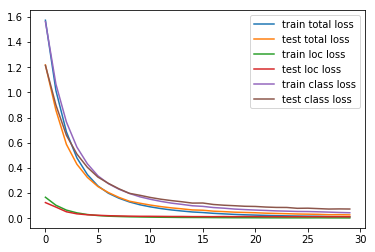

In [ ]:
epochs = [i for i in range(len(train_loss_hist))]
plt.plot(epochs , [i[0] for i in train_loss_hist], label = 'train total loss')
plt.plot(epochs , [i[0] for i in test_loss_hist], label = 'test total loss')
plt.plot(epochs , [i[1] for i in train_loss_hist], label = 'train loc loss')
plt.plot(epochs , [i[1] for i in test_loss_hist], label = 'test loc loss')
plt.plot(epochs , [i[2] for i in train_loss_hist], label = 'train class loss')
plt.plot(epochs , [i[2] for i in test_loss_hist], label = 'test class loss')
plt.legend()
plt.show()

In [ ]:
def plot_boxes(img, bbox1 , bbox2, w, h, color1='red' , color2 = 'green'):
    """ Plot bounding box on the image tensor. 
    """
    img = img.cpu().numpy().transpose((1, 2, 0))  # (H, W, C)
    
    # denormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    # bounding box
    bb1 = np.array(bbox1)
    bb2 = np.array(bbox2)
    w , h = w.data.item() , h.data.item()
    bx1, by1 = (bb1[0] * w), (bb1[1] * h)
    bw1, bh1 = (bb1[2] * w), (bb1[3] * h)
    
    bx2, by2 = (bb2[0] * w), (bb2[1] * h)
    bw2, bh2 = (bb2[2] * w), (bb2[3] * h)
    
    ######################################################
    print(bx1 , by1 , bw1, bh1)
    print(type(bbox1))
    print(w , h)
    ######################################################
    # scale image
    img = cv2.resize(img, (w, h))
    
    # create BB rectangle
    rect1 = plt.Rectangle((bx1, by1), bw1, bh1, color=color1, fill=False, lw=3)
    rect2 = plt.Rectangle((bx2, by2), bw2, bh2, color=color2, fill=False, lw=3)
    # plot
    plt.figure(figsize=(12, 8))
    plt.axis('off')
    plt.imshow(img)
    plt.gca().add_patch(rect1)
    plt.gca().add_patch(rect2)
    plt.show()

[[0.95 0.05 0.07 0.06 0.08 0.08 0.06 0.05]
 [0.05 0.05 0.05 0.07 0.09 0.08 0.82 0.09]
 [0.05 0.06 0.06 0.05 0.91 0.07 0.08 0.05]
 [0.94 0.05 0.06 0.06 0.08 0.08 0.07 0.05]
 [0.08 0.05 0.81 0.07 0.11 0.09 0.07 0.08]]
[[0.51 0.57 0.14 0.2 ]
 [0.44 0.47 0.08 0.21]
 [0.53 0.39 0.37 0.45]
 [0.64 0.4  0.26 0.21]
 [0.19 0.38 0.24 0.2 ]]
predicted : ALB
target: ALB
653.616943359375 411.3767910003662 178.0109977722168 144.67113375663757
<class 'list'>
1280 720


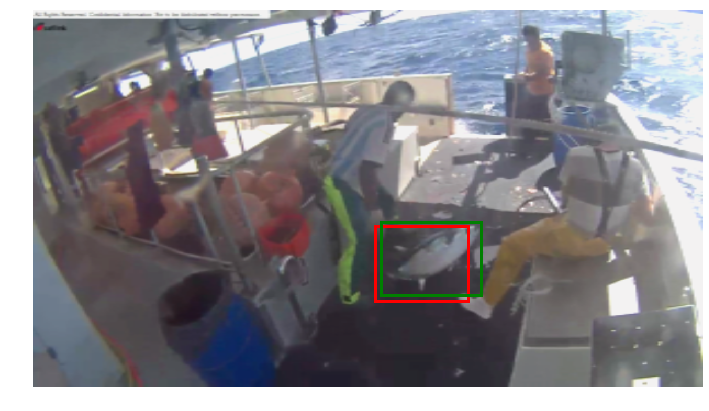

predicted : SHARK
target: SHARK
563.262825012207 341.8822145462036 104.94315147399902 147.99432635307312
<class 'list'>
1280 720


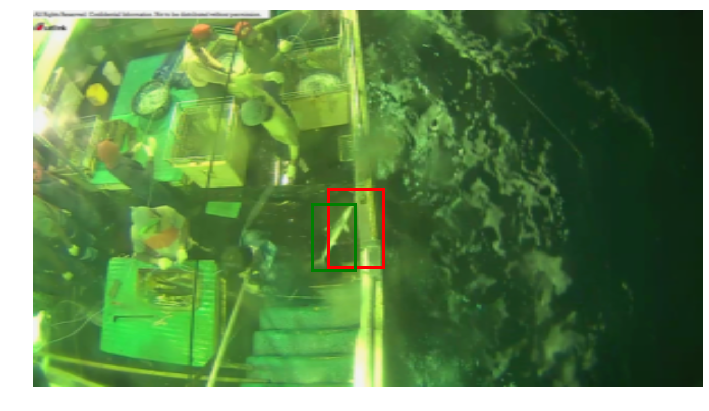

predicted : NoF
target: NoF
674.7236633300781 279.4302177429199 473.56712341308594 323.5216784477234
<class 'list'>
1280 720


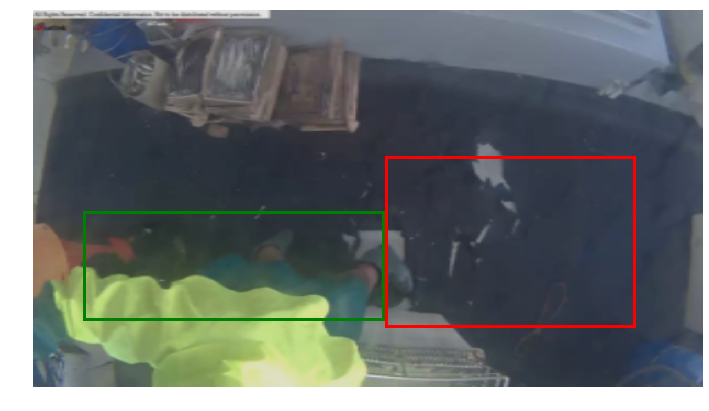

predicted : ALB
target: ALB
825.3382873535156 288.6725950241089 339.16980743408203 147.6353931427002
<class 'list'>
1280 720


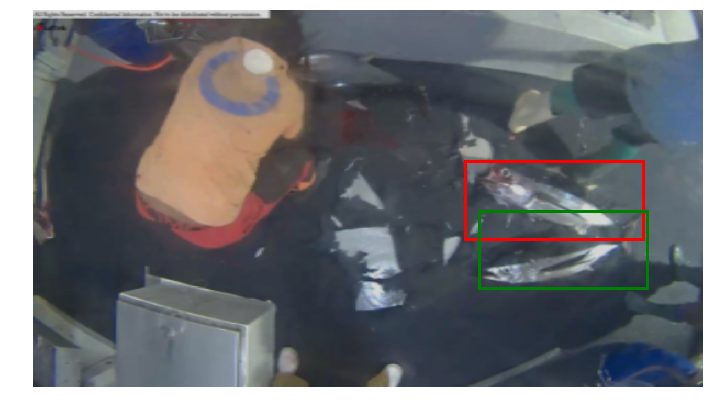

predicted : DOL
target: DOL
238.03089141845703 287.76146471500397 303.9864158630371 151.09338238835335
<class 'list'>
1280 750


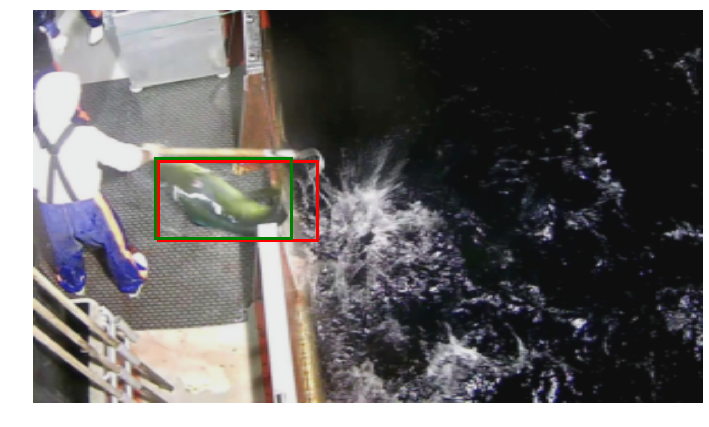

In [ ]:
test_dl  = DataLoader(test_ds  , batch_size = 5  , shuffle = True, num_workers=1)
imgs, targets, sizes = next(iter(test_dl))
locs, scores = model(to_var(imgs))
bboxes = targets[:,:4]
scores = scores.data.cpu().numpy()
locs = locs.data.cpu().numpy()
#####################################
print(scores)
print(locs)
#####################################
for i in range(locs.shape[0] ):
    pred_lbl = np.argmax(scores[i])
    pred_bb = locs[i].tolist()
    w, h = sizes[0][i], sizes[1][i]
    print('predicted :',test_ds.ds.classes[pred_lbl])
    print('target:' ,test_ds.ds.classes[np.argmax(targets[i].cpu().numpy())-4])
    ######################################
#     print(pred_bb)
    ######################################
    plot_boxes(imgs[i], pred_bb,bboxes[i,:].tolist() ,w, h)